### Data Transformation
Perform the same data transformation method

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler

#Load the clean data and the raw dataset which will be used for the model fitting.
raw_data = pd.read_csv("/Users/Lex/Documents/GitHub/TimeSeries_Project/Data/CovidSG_Latest_Data.csv")
Stationary_data = pd.read_csv("/Users/Lex/Documents/GitHub/TimeSeries_Project/Data/Clean_CovidSG_Data.csv")

raw_data

,Date,Daily_Confirmed,Daily_Discharged,Daily_Local_Transmission
0,1/30/2020,3,0,0
1,1/31/2020,3,0,0
2,2/1/2020,2,0,0
3,2/2/2020,0,0,0
4,2/3/2020,0,0,0
...,...,...,...,...
666,11/26/2021,1090,2233,1086
667,11/27/2021,1761,1897,1752
668,11/28/2021,747,2061,744
669,11/29/2021,1103,1811,1095


In [2]:
#Assign x and y values
#Assign them into different Data Frames
#Set date as an index
X = raw_data.Date
y_confirmed = raw_data.Daily_Confirmed
y_discharged = raw_data.Daily_Discharged
y_localTransmission = raw_data.Daily_Local_Transmission

#Concatenate x and y data
Confirmed_data = pd.concat([X, y_confirmed], axis=1)
Discharged_data = pd.concat([X, y_discharged], axis=1)
LocalTransmission_data = pd.concat([X, y_localTransmission], axis=1)

Confirmed_data = Confirmed_data.set_index('Date')
Discharged_data = Discharged_data.set_index('Date')
LocalTransmission_data = LocalTransmission_data.set_index('Date')

In [3]:
def split_data(dataframe):
    train_size = int(len(dataframe) * 0.70)
    train_data = dataframe.iloc[:train_size]
    test_data = dataframe.iloc[train_size:]
    return train_data, test_data

def scaler(dataframe):
    scaler = MinMaxScaler().fit(dataframe)

    scaled_data = scaler.transform(dataframe)
    return scaled_data

#Split Data
Confirmed_Train, Confirmed_Test = split_data(Confirmed_data)
Discharged_Train, Discharged_Test = split_data(Discharged_data)
LocalTransmission_Train, LocalTransmission_Test = split_data(LocalTransmission_data)

#Rescale Data
Confirmed_Train, Confirmed_Test = scaler(dataframe = Confirmed_Train), scaler(dataframe = Confirmed_Test)
Discharged_Train, Discharged_Test = scaler(dataframe = Discharged_Train), scaler(dataframe = Discharged_Test)
LocalTransmission_Train, LocalTransmission_Test = scaler(dataframe = LocalTransmission_Train), scaler(dataframe = LocalTransmission_Test)

In [4]:
print(len(Confirmed_Train))
print(len(Confirmed_Test))

469
202


In [5]:
#Reshape the dataset as an input to an Gated Recurrent Unit
#lookback is the amount of memory(past observation) that the GRU is gonna retain.
#Forecast is 30 days = 1 month (Month of December)
#Historical data should account at least double the amount of Forecast.
#x1, y1 = Confirmed; x2, y2 = Discharged; x3, y3 = Local Transmission
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

x1_train, y1_train = create_dataset(Confirmed_Train, 90)
x1_test, y1_test = create_dataset(Confirmed_Test, 90)
x2_train, y2_train = create_dataset(Discharged_Train, 90)
x2_test, y2_test = create_dataset(Discharged_Test, 90)
x3_train, y3_train = create_dataset(LocalTransmission_Train, 90)
x3_test, y3_test = create_dataset(LocalTransmission_Test, 90)

In [6]:
x1_train.shape

(379, 90, 1)

In [7]:
#Create the LSTM and GRU Model
import tensorflow as tf
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

def LSTM_Model(input_shape, units):
    model = Sequential(name = 'LSTM')
    model.add(LSTM(units = units, return_sequences = False, input_shape = input_shape))
    model.add(Dropout(0.5))
    #model.add(GRU(64))
    #model.add(Dropout(0.15))
    model.add(Dense(1, activation='sigmoid'))
    return model

def GRU_Model(input_shape, units):
    model = Sequential(name = 'GRU')
    model.add(GRU(units = units, return_sequences = False, input_shape = input_shape))
    model.add(Dropout(0.8))
    #model.add(GRU(64))
    #model.add(Dropout(0.15))
    model.add(Dense(1, activation='sigmoid'))
    return model

def plot_loss(history, model_name):
    plt.figure(figsize = (8, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.show()

In [8]:
model_Confirmed = GRU_Model(input_shape = (x1_train.shape[1], x1_train.shape[2]), units = 16)
model_Confirmed.compile(optimizer = Adam(0.0001), loss = 'mean_squared_error')
model_Confirmed.summary()

Model: "GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                912       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
12/12 [==============================] - 4s 98ms/step - loss: 0.1906 - val_loss: 0.0905
Epoch 2/100
12/12 [==============================] - 1s 45ms/step - loss: 0.1885 - val_loss: 0.0897
Epoch 3/100
12/12 [==============================] - 0s 39ms/step - loss: 0.1866 - val_loss: 0.0890
Epoch 4/100
12/12 [==============================] - 0s 39ms/step - loss: 0.1852 - val_loss: 0.0882
Epoch 5/100
12/12 [==============================] - 0s 37ms/step - loss: 0.1832 - val_loss: 0.0875
Epoch 6/100
12/12 [==============================] - 0s 37ms/step - loss: 0.1804 - val_loss: 0.0867
Epoch 7/100
12/12 [==============================] - 1s 46ms/step - loss: 0.1791 - val_loss: 0.0860
Epoch 8/100
12/12 [==============================] - 1s 46ms/step - loss: 0.1768 - val_loss: 0.0852
Epoch 9/100
12/12 [==============================] - 1s 46ms/step - loss: 0.1743 - val_loss: 0.0845
Epoch 10/100
12/12 [==============================] - 1s 44ms/step - loss: 0.1722 - val_loss: 0.0837

Epoch 82/100
12/12 [==============================] - 0s 37ms/step - loss: 0.0310 - val_loss: 0.1550
Epoch 83/100
12/12 [==============================] - 0s 37ms/step - loss: 0.0347 - val_loss: 0.1551
Epoch 84/100
12/12 [==============================] - 1s 43ms/step - loss: 0.0296 - val_loss: 0.1553
Epoch 85/100
12/12 [==============================] - 1s 43ms/step - loss: 0.0323 - val_loss: 0.1554
Epoch 86/100
12/12 [==============================] - 0s 38ms/step - loss: 0.0311 - val_loss: 0.1557
Epoch 87/100
12/12 [==============================] - 0s 40ms/step - loss: 0.0269 - val_loss: 0.1559
Epoch 88/100
12/12 [==============================] - 0s 40ms/step - loss: 0.0343 - val_loss: 0.1560
Epoch 89/100
12/12 [==============================] - 0s 38ms/step - loss: 0.0354 - val_loss: 0.1561
Epoch 90/100
12/12 [==============================] - 0s 41ms/step - loss: 0.0351 - val_loss: 0.1563
Epoch 91/100
12/12 [==============================] - 0s 42ms/step - loss: 0.0327 - val_los

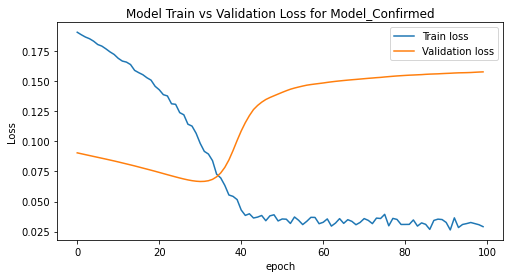

In [9]:
#Train GRU on Confirmed Cases Data
history_data1 = model_Confirmed.fit(x1_train, y1_train, batch_size = 32, epochs = 100, validation_data = (x1_test, y1_test), shuffle=False)
plot_loss(history_data1, "Model_Confirmed")

In [10]:
#Test the model for predictions
#Transform data back to original data space
def inverse(dataframe):
    scaler = MinMaxScaler().fit(dataframe)

    scaled_data = scaler.inverse_transform(dataframe)
    return scaled_data

y1_test = inverse(y1_test)
y1_train = inverse(y1_train)
y2_test = inverse(y2_test)
y2_train = inverse(y2_train)
y3_test = inverse(y3_test)
y3_train = inverse(y3_train)

#Function for prediction
def prediction(model, testx_inst):
    prediction = model.predict(testx_inst)
    prediction = inverse(prediction)
    return prediction

#Function for plotting the observed and predicted values
def plot_future(prediction, model_name, testy_inst):
    
    plt.figure(figsize=(15, 4))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(testy_inst), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Dates')
    plt.ylabel('Number of Cases')

#Function that evaluates the predictions
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)

    print(model_name + ':')
    print('\nMean Squared Error:', mse)
    print('Root Mean Square Error:', rmse)

Model_Confirmed:

Mean Squared Error: 0.15952479397630462
Root Mean Square Error: 0.39940555075800416


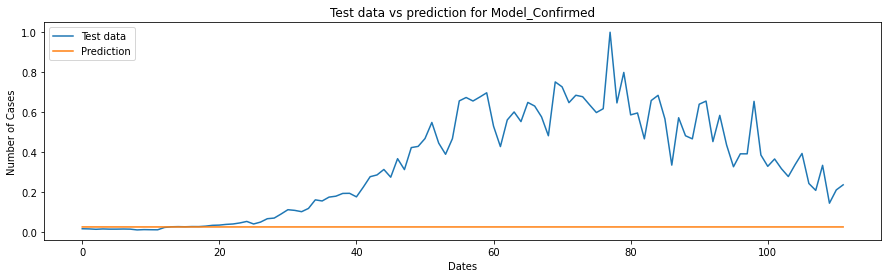

In [11]:
prediction_confirmed = prediction(model_Confirmed, x1_test)
plot_future(prediction_confirmed, "Model_Confirmed", y1_test)
evaluate_prediction(prediction_confirmed, y1_test, "Model_Confirmed")